Wybieramy temat. Może być to temat z pierwszego projektu. Jeśli pozostajemy przy tym 
samym temacie musimy znaleźć zmienną celu. 
2. Dokonujemy eksploracji zbioru. Uzupełniamy braki danych. Dokonujemy wstępnej selekcji 
zmiennych.   
3. Dzielimy zbiór danych na treningowy testowy i w miarę możliwości na walidacyjny. 
4. Tworzymy minimum 3 modele predykcyjne (może być ich więcej) wraz z dostrojeniem 
hiperparametrów. 
5. Porównać i wybrać najlepszy model. 
6. Dokonać ostatecznej oceny wybranego modelu na zbiorze walidacyjnym. 
7. Wskazać uzysk dla firmy / odbiorcy (np. ile pieniędzy z tego będzie miała, jak wdrożenie 
wpłynie na rozpoznawalność przypadków, dla których firma wykona działania prewencyjne 
itd.) 
8. Stworzenie aplikacji wykorzystującej model 
9. Na prezentacji powinna znaleźć się krótka analiza zmiennych, omówienie wyników 
wszystkich zastosowanych technik modelowania i ich porównanie, wybór modelu i przede 
wszystkim wartość dodana jaką niesie za sobą wdrożenie

4. Odejdzie  czy nie odejdzie?  – prognozowanie zjawiska churn wśród Klientów telecom  
• Prognozowanie czy jest zagrożenie, że Klient zrezygnuje z usług firmy 
• Aplikacja dla pracowników informująca o zagrożeniu odejścia Klienta 
• https://www.kaggle.com/blastchar/telco-customer-churn 
 


In [1]:
#Import libraries
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest,mutual_info_classif, f_classif, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV,validation_curve,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score,recall_score,f1_score, roc_auc_score, make_scorer,roc_curve
from sklearn.preprocessing import StandardScaler,MinMaxScaler, Normalizer, LabelEncoder,OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chi2
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

plt.rcParams["figure.figsize"] = (20,3) 

c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Data Import

In [2]:
#Import data 
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#During training attempt it turned out TotalCharges has empty strings and cannot be converted to number, let's remove it. 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.dropna(inplace=True)

#drop customer ID as not useful
df.drop('customerID',axis=1,inplace=True)

Split df into X,y and into test, val, train

In [3]:
#Define X,y
X=df.drop(columns='Churn')
y=df['Churn']

#Encode y
le=LabelEncoder()
y=le.fit_transform(y)

#Splity X,y into train, val, test
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=44,train_size=0.6,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state=44,train_size=0.5,stratify=y_val)

print(X_train.shape,y_train.shape,y_train.sum()/len(y_train))
print(X_val.shape,y_val.shape,y_val.sum()/len(y_val))
print(X_test.shape,y_test.shape,y_test.sum()/len(y_test))

(4219, 19) (4219,) 0.2657027731689974
(1406, 19) (1406,) 0.26600284495021337
(1407, 19) (1407,) 0.2658137882018479


Pipeline definition for X transformation

In [5]:
#Lets split features by type 
cols_num=X.select_dtypes(include=['float64','int64']).columns
cols_cat=X.select_dtypes(include='object').columns

#Lets define pipeline that will use standard scale on numerical, onehotencoder on categorical and then run randomforrest
#lets apply standard scaler to numerical columns 
trans_num = Pipeline(steps = [
    ('num_trans', StandardScaler())
])

#lets apply one hot encoder to categorical columns
trans_cat = Pipeline(steps = [
    ('cat_trans', OneHotEncoder(drop='first'))
])

# combine above transformers into preprocessor that will transform numerical by standardscaler and categoricaly by onehot
prep_std_onehot = ColumnTransformer(transformers = [
    ('numerical', trans_num, cols_num),
    ('categorical', trans_cat, cols_cat)
])

#let's define pipe that will do preprocessing (standard scaler + one hot encoder) and then randomforrest
std_onehot_not_tuned = Pipeline(steps = [
                ('preprocessor', prep_std_onehot),
                ('classifier', RandomForestClassifier(random_state=44,n_jobs=-1))
            ])


#Lets define another pipeline that will use standard scaler on numerical, ordinal encoder on categorical and then run randomforrest

#Lets define encoding for features the order on the list corresponds with value 
gender_cat=['Male','Female']
partner_cat=['No','Yes']
dependents_cat=['No','Yes']
phoneService_cat=['No','Yes']
multiplelines_cat=['No','Yes','No phone service']
internetservice_cat=['No','DSL','Fiber optic']
onlinesecurity_cat=['No internet service','No','Yes']
onlinebackup_cat=['No internet service','No','Yes']
deviceprotection_cat=['No internet service','No','Yes']
techsupport_cat=['No internet service','No','Yes']
streamingtv_cat=['No internet service','No','Yes']
streamingmovies_cat=['No internet service','No','Yes']
contract_cat=['Month-to-month','One year','Two year']
paperlessbilling_cat=['No','Yes']
paymentmethod_cat=['Mailed check','Electronic check','Bank transfer (automatic)','Credit card (automatic)']

# lets wrap all of those encoding list into one with same order as they appear in df
cat_list=[gender_cat,partner_cat,dependents_cat,phoneService_cat,multiplelines_cat,internetservice_cat,onlinesecurity_cat,onlinebackup_cat,deviceprotection_cat,
techsupport_cat,streamingtv_cat,streamingmovies_cat,contract_cat,paperlessbilling_cat,paymentmethod_cat]

#lets apply ordinal encoding 
trans_cat_ordinal = Pipeline(steps = [
    ('cat_trans', OrdinalEncoder(categories=cat_list))
])

prep_std_ordinal = ColumnTransformer(transformers = [
    ('numerical', trans_num, cols_num),
    ('categorical', trans_cat_ordinal, cols_cat)
])

std_ordinal_not_tuned = Pipeline(steps = [
                ('preprocessor', prep_std_ordinal),
                ('classifier', RandomForestClassifier(random_state=44,n_jobs=-1))
            ])

In [6]:
def results_print(model):
    """function takes model and prints scores"""
    pred_train=model.predict(X_train)
    pred_val=model.predict(X_val)
    print('Train F1, Precision, Recall')
    print(f1_score(y_train,pred_train))
    print(precision_score(y_train,pred_train))
    print(recall_score(y_train,pred_train))
    print('Val F1, Precision, Recall')
    print(f1_score(y_val,pred_val))
    print(precision_score(y_val,pred_val))
    print(recall_score(y_val,pred_val))

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

def results_print_treshold(model,t):
    """function takes model and prints scores depedning on treshold t"""
    prob_train=model.predict_proba(X_train)[:,1]
    prob_val=model.predict_proba(X_val)[:,1]
    print('Results for treshold {}'.format(t))
    print('F1 score with optimal treshold',f1_score(y_val,to_labels(prob_val,t)))
    print(classification_report(y_val,to_labels(prob_val,t)))
    print('Train F1, Precision, Recall')
    print(f1_score(y_train,to_labels(prob_train,t)))
    print(precision_score(y_train,to_labels(prob_train,t)))
    print(recall_score(y_train,to_labels(prob_train,t)))
    print('Val F1, Precision, Recall')
    print(f1_score(y_val,to_labels(prob_val,t)))
    print(precision_score(y_val,to_labels(prob_val,t)))
    print(recall_score(y_val,to_labels(prob_val,t)))

Evaluate std_onehot_not_tuned (base model).

In [12]:
#Fit model
std_onehot_not_tuned.fit(X_train,y_train)

#Evaluate model
results_print(std_onehot_not_tuned)

Train F1, Precision, Recall
0.9968819599109132
0.9955516014234875
0.9982158786797503
Val F1, Precision, Recall
0.580060422960725
0.6666666666666666
0.5133689839572193


Evaluate std_ordinal_not_tuned (standard scaler + ordinal encoding).

It's 0.0028 better on recall form based model

In [13]:
#Fit model
std_ordinal_not_tuned.fit(X_train,y_train)

#Evaluate model
results_print(std_ordinal_not_tuned)

Train F1, Precision, Recall
0.9968819599109132
0.9955516014234875
0.9982158786797503
Val F1, Precision, Recall
0.593939393939394
0.6853146853146853
0.5240641711229946


Tune & Evaluate std_one_hot hyperparams. 

In [7]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_onehot_tuned=GridSearchCV(std_onehot_not_tuned,params_grid,scoring='f1',n_jobs=-1,verbose=2)

#Find the optimal hyperparmeters
std_onehot_tuned.fit(X_train,y_train)

#print optimal paramaters
std_onehot_tuned.best_params_

#Evaluate model
results_print(std_onehot_tuned)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Train F1, Precision, Recall
0.7086792452830188
0.6141268803139307
0.8376449598572703
Val F1, Precision, Recall
0.654292343387471
0.5778688524590164
0.7540106951871658


Evaluate std_onehot_tuned with best treshold.

Its better by 0.3248 on recall than our base model



In [43]:
std_onehot_tuned.cv_results_

{'mean_fit_time': array([0.9401413 , 0.87011747, 0.85209126, 0.80776291, 0.76017818,
        0.71474729, 0.42391524, 0.41103597, 0.38390684, 0.40603771,
        0.3953763 , 0.33302455, 0.45936837, 0.42727013, 0.34818549,
        0.37338805, 0.40750008, 0.37096386, 0.47614441, 0.50327473,
        0.55903172, 0.48964977, 0.54416938, 0.54842715, 0.36357045,
        0.32166753, 0.31768298, 0.340311  , 0.31278443, 0.31777434,
        0.3327322 , 0.29776545, 0.32287574, 0.30658574, 0.31315022,
        0.33942819, 0.59541459, 0.65167923, 0.58254714, 0.65928783,
        0.61359215, 0.61927285, 0.36101389, 0.35444007, 0.35150328,
        0.32145257, 0.33284721, 0.31069016, 0.33845239, 0.34870691,
        0.36243525, 0.33859777, 0.33159575, 0.3338695 , 0.67942533,
        0.76461344, 0.709231  , 0.72580023, 0.65486574, 0.61072836,
        0.4424552 , 0.4440351 , 0.44109759, 0.39636602, 0.36912436,
        0.34725995, 0.35355682, 0.36274238, 0.37908278, 0.34551387,
        0.36185112, 0.41811953,

Best Threshold=0.451733, G-Mean=0.780


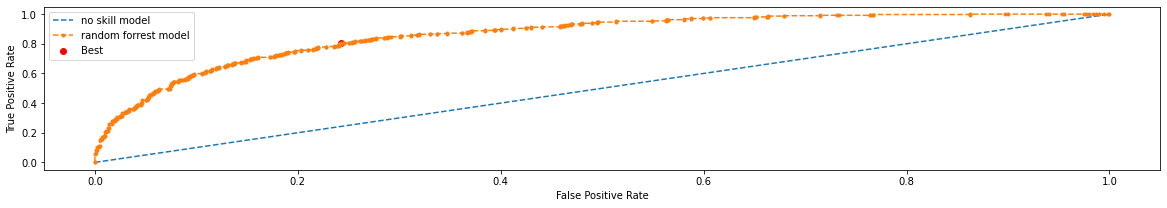

Results for treshold 0.4517331326187367
F1 score with optimal treshold 0.647887323943662
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1032
           1       0.54      0.80      0.65       374

    accuracy                           0.77      1406
   macro avg       0.73      0.78      0.74      1406
weighted avg       0.81      0.77      0.78      1406

Train F1, Precision, Recall
0.7045133991537378
0.5825072886297377
0.8911685994647636
Val F1, Precision, Recall
0.647887323943662
0.5446265938069217
0.7994652406417112


In [15]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_onehot_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_onehot_tuned,thresholds[ix])

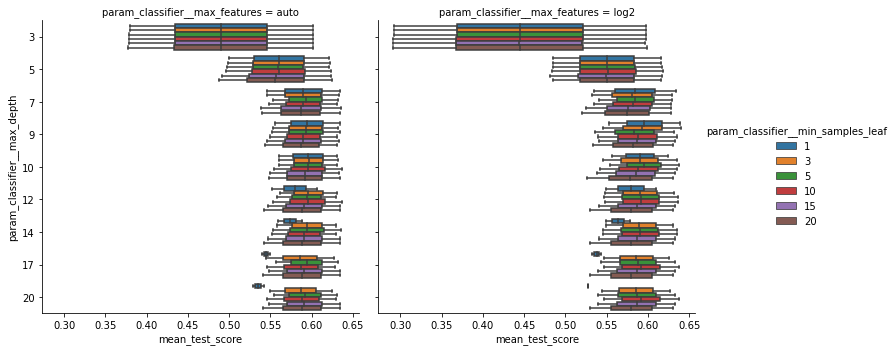

In [16]:
#Lets visualize Gridsearh results
results=pd.DataFrame(std_onehot_tuned.cv_results_)

#Shows f1 score depending on max depth (y_axis) and min_samples_leaf(color). This needs loop to split other dimension (i.e. max_features, class_weight)
sns.catplot(data=results, x='mean_test_score', y='param_classifier__max_depth',hue='param_classifier__min_samples_leaf',kind="box",col="param_classifier__max_features")

# sns.lineplot(data=results,x='param_classifier__max_depth',y='mean_test_score')

# sns.relplot(
#     data=results,x='param_classifier__max_depth', y='mean_test_score',
#     col='param_classifier__max_features',
#     kind="line"
# )

Try undersampling - std_onehot_undersampled_not_tuned

In [17]:
# define model
model = RandomForestClassifier(random_state=44,n_jobs=-1)
# define resampling
under = RandomUnderSampler(sampling_strategy=0.5)

from imblearn.pipeline import Pipeline as imbPipeline
# define pipeline
std_onehot_undersample = imbPipeline(steps=[('u', under), ('e',prep_std_onehot), ('classifier', model)])

In [18]:
std_onehot_undersample.fit(X_train,y_train)

Pipeline(steps=[('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('e',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 

Evaluate std_onehot_undersampled_not_tuned

Its 0.1624 better on recall than our base model

In [19]:
#Evaluate model
results_print(std_onehot_undersample)

Train F1, Precision, Recall
0.9514893617021278
0.9096826688364524
0.9973238180196253
Val F1, Precision, Recall
0.6046511627906977
0.6190476190476191
0.5909090909090909


Tune std_onehot_undersampled hyperparameters

In [20]:
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_onehot_undersampled_tuned=GridSearchCV(std_onehot_undersample,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [21]:
std_onehot_undersampled_tuned.fit(X_train,y_train)
std_onehot_undersampled_tuned.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 12,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 10}

Evaluate std_onehot_undersampled_tuned
Its better on recall by 0.3590



In [22]:
#Evaluate model
results_print(std_onehot_undersampled_tuned)

Train F1, Precision, Recall
0.684678016284234
0.5850727387729285
0.8251561106155219
Val F1, Precision, Recall
0.6599326599326599
0.5686653771760155
0.786096256684492


Evaluate std_onehot_undersampled_tuned with best treshold

Its 0.3391 better on recall than base model

Best Threshold=0.501222, G-Mean=0.785


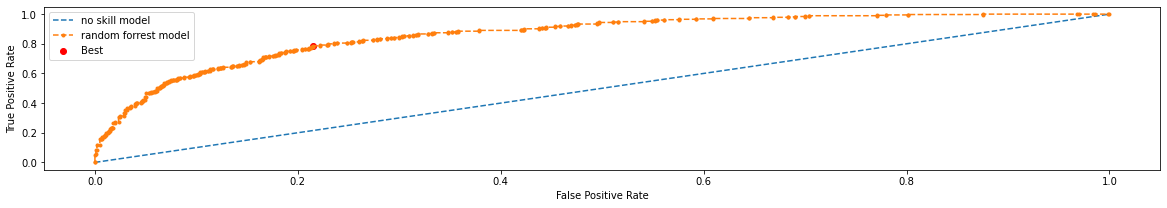

Results for treshold 0.5012223299790413
F1 score with optimal treshold 0.6606741573033708
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1032
           1       0.57      0.79      0.66       374

    accuracy                           0.79      1406
   macro avg       0.74      0.79      0.75      1406
weighted avg       0.82      0.79      0.79      1406

Train F1, Precision, Recall
0.683957021118933
0.5849176172370089
0.8233719892952721
Val F1, Precision, Recall
0.6606741573033708
0.5697674418604651
0.786096256684492


In [23]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_onehot_undersampled_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_onehot_undersampled_tuned,thresholds[ix])

#Tune std_ordinal hyperparameters

In [24]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_ordinal_tuned=GridSearchCV(std_ordinal_not_tuned,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [25]:
#Find the optimal hyperparmeters
std_ordinal_tuned.fit(X_train,y_train)

#print optimal paramaters
std_ordinal_tuned.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 7,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 1}

Evaluate std_ordinal_tuned

Its 0.3391  better than base model

In [26]:
#See the precision, recall & f1 score for train and val with optimal hyperparameters
#Evaluate model
results_print(std_ordinal_tuned)

Train F1, Precision, Recall
0.6822742474916388
0.5847133757961783
0.8189116859946476
Val F1, Precision, Recall
0.6440677966101696
0.5577299412915852
0.7620320855614974


(54,82) std_ordinal_tuned with best treshold

Best Threshold=0.469509, G-Mean=0.780


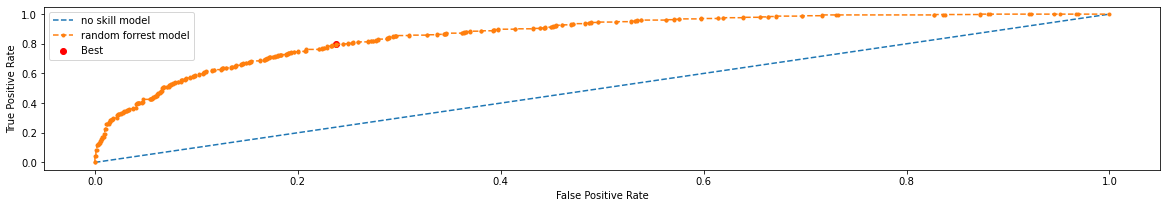

Results for treshold 0.4695091547441045
F1 score with optimal treshold 0.6484716157205241
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1032
           1       0.55      0.79      0.65       374

    accuracy                           0.77      1406
   macro avg       0.73      0.78      0.74      1406
weighted avg       0.81      0.77      0.78      1406

Train F1, Precision, Recall
0.6837606837606839
0.5690574985180794
0.856378233719893
Val F1, Precision, Recall
0.6484716157205241
0.5479704797047971
0.7941176470588235


In [27]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_ordinal_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_ordinal_tuned,thresholds[ix])

Evaluate std_ordinal_undersampled_not_tuned

In [28]:
# define model
model2 = RandomForestClassifier(random_state=44,n_jobs=-1)
# define resampling
# under = RandomUnderSampler(sampling_strategy=0.5)

# prep_std_onehot2 = ColumnTransformer(transformers = [
#     ('numerical', trans_num, cols_num),
#     ('categorical', trans_cat, cols_cat)
# ])

# prep_std_ordinal = ColumnTransformer(transformers = [
#     ('numerical', trans_num, cols_num),
#     ('categorical', trans_cat_ordinal, cols_cat)
# ])


from imblearn.pipeline import Pipeline as imbPipeline
# define pipeline
# std_onehot_undersample2 = imbPipeline(steps=[('u', under2), ('e',prep_std_onehot2), ('classifier', model2)])

std_ordinal_undersampled_not_tuned = imbPipeline(steps=[('u', under), ('e',prep_std_ordinal), ('classifier', model2)])
std_ordinal_undersampled_not_tuned.fit(X_train,y_train)

Pipeline(steps=[('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('e',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OrdinalEncoder(categories=[['Male',
                                                                                               'Female'],
                                                                                              ['No',
                                                                                         

In [29]:
results_print(std_ordinal_undersampled_not_tuned)


Train F1, Precision, Recall
0.9471011426153194
0.9009661835748792
0.9982158786797503
Val F1, Precision, Recall
0.5948855989232841
0.5989159891598916
0.5909090909090909


Evaluate std_ordinal_undersampled_tuned

In [30]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_ordinal_undersampled_tuned=GridSearchCV(std_ordinal_not_tuned,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [31]:
std_ordinal_undersampled_tuned.fit(X_train,y_train)
std_ordinal_undersampled_tuned.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 7,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 1}

In [32]:
results_print(std_ordinal_undersampled_tuned)

Train F1, Precision, Recall
0.6822742474916388
0.5847133757961783
0.8189116859946476
Val F1, Precision, Recall
0.6440677966101696
0.5577299412915852
0.7620320855614974


(54,82) std_ordinal_undersampled_tuned with best treshold

Best Threshold=0.469509, G-Mean=0.780


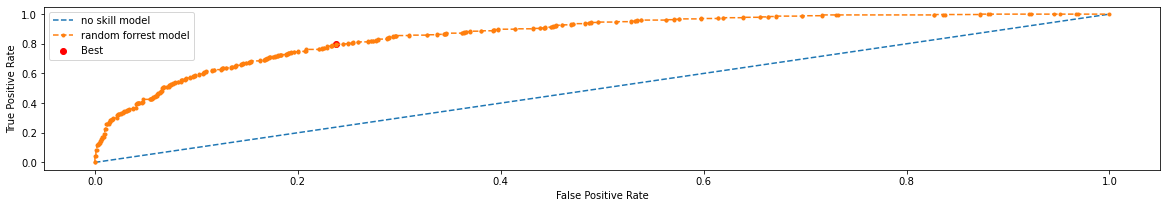

Results for treshold 0
F1 score with optimal treshold 0.4202247191011236
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1032
           1       0.27      1.00      0.42       374

    accuracy                           0.27      1406
   macro avg       0.13      0.50      0.21      1406
weighted avg       0.07      0.27      0.11      1406

Train F1, Precision, Recall
0.4198501872659176
0.2657027731689974
1.0
Val F1, Precision, Recall
0.4202247191011236
0.26600284495021337
1.0


c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_ordinal_undersampled_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_ordinal_undersampled_tuned,0)

In [34]:
#Lets aggregate results

# will iterate over those models
models={
    "std_onehot_not_tuned": std_onehot_not_tuned,
    "std_onehot_tuned": std_onehot_tuned,
    "std_onehot_undersampled_not_tuned": std_onehot_undersample,
    "std_onehot_undersampled_tuned": std_onehot_undersampled_tuned,
    "std_ordinal_not_tuned": std_ordinal_not_tuned,
    "std_ordinal_tuned": std_ordinal_tuned,
    "std_ordinal_undersampled_not_tuned": std_ordinal_undersampled_not_tuned,
    "std_ordinal_undersampled_tuned": std_ordinal_undersampled_tuned
}



#we will use this function to collect results
def collect_results(model_lst):
    #we will use those lists to collect results
    model_list=[]
    f1_train=[]
    prec_train=[]
    rec_train=[]
    f1_val=[]
    prec_val=[]
    rec_val=[]
    
    #we will use those lists to collect results with optimal treshold
    f1_train_t=[]
    prec_train_t=[]
    rec_train_t=[]
    f1_val_t=[]
    prec_val_t=[]
    rec_val_t=[]
    t_=[]
    for model in model_lst:
        model_list.append(model)
        print(model)
        f1_train.append(f1_score(y_train,model_lst[model].predict(X_train)))
        prec_train.append(precision_score(y_train,model_lst[model].predict(X_train)))
        rec_train.append(recall_score(y_train,model_lst[model].predict(X_train)))
        f1_val.append(f1_score(y_val,model_lst[model].predict(X_val)))
        prec_val.append(precision_score(y_val,model_lst[model].predict(X_val)))
        rec_val.append(recall_score(y_val,model_lst[model].predict(X_val)))
        #here is the part that calculates score with different tresholds
        #for each model it calculates optimal tresholds on val and then shows score for both train and val
        fpr, tpr, thresholds = roc_curve(y_val, model_lst[model].predict_proba(X_val)[:,1])
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        t=thresholds[ix]
        prob_train=model_lst[model].predict_proba(X_train)[:,1]
        prob_val=model_lst[model].predict_proba(X_val)[:,1]
        f1_train_t.append(f1_score(y_train,to_labels(prob_train,t)))
        prec_train_t.append(precision_score(y_train,to_labels(prob_train,t)))
        rec_train_t.append(recall_score(y_train,to_labels(prob_train,t)))
        t_.append(t)

        f1_val_t.append(f1_score(y_val,to_labels(prob_val,t)))
        prec_val_t.append(precision_score(y_val,to_labels(prob_val,t)))
        rec_val_t.append(recall_score(y_val,to_labels(prob_val,t)))

    return pd.DataFrame({'model': model_list, 'f1_train': f1_train, 'precision_train': prec_train,'recall_train': rec_train,
    'f1_val': f1_val, 'precision_val': prec_val,'recall_val': rec_val, 't_': t_, 'f1_train_t': f1_train_t, 'precision_train_t': prec_train_t,'recall_train_t': rec_train_t,
    'f1_val_t': f1_val_t, 'precision_val_t': prec_val_t,'recall_val_t': rec_val_t
    })

def results_print_treshold(model,t):
    """function takes model and prints scores depedning on treshold t"""
    prob_train=model.predict_proba(X_train)[:,1]
    prob_val=model.predict_proba(X_val)[:,1]
    print('Results for treshold {}'.format(t))
    print('F1 score with optimal treshold',f1_score(y_val,to_labels(prob_val,t)))
    print(classification_report(y_val,to_labels(prob_val,t)))
    print('Train F1, Precision, Recall')
    print(f1_score(y_train,to_labels(prob_train,t)))
    print(precision_score(y_train,to_labels(prob_train,t)))
    print(recall_score(y_train,to_labels(prob_train,t)))
    print('Val F1, Precision, Recall')
    print(f1_score(y_val,to_labels(prob_val,t)))
    print(precision_score(y_val,to_labels(prob_val,t)))
    print(recall_score(y_val,to_labels(prob_val,t)))

Compare models

In [35]:
display(collect_results(models))
# pipeline.predict(X_train)

# f1_=[]

# taratara = {'mod1': pipe}
# for key in taratara:
#     print(f1_score(y_train,taratara[key].predict(X_train)))
#     f1_.append(f1_score(y_train,taratara[key].predict(X_train)))

# print(f1_)

std_onehot_not_tuned
std_onehot_tuned
std_onehot_undersampled_not_tuned
std_onehot_undersampled_tuned
std_ordinal_not_tuned
std_ordinal_tuned
std_ordinal_undersampled_not_tuned
std_ordinal_undersampled_tuned


,model,f1_train,precision_train,recall_train,f1_val,precision_val,recall_val,t_,f1_train_t,precision_train_t,recall_train_t,f1_val_t,precision_val_t,recall_val_t
0,std_onehot_not_tuned,0.833828,0.935627,0.752007,0.540984,0.699153,0.441176,0.310000,0.859867,0.803253,0.925067,0.639906,0.572939,0.724599
1,std_onehot_tuned,0.708679,0.614127,0.837645,0.654292,0.577869,0.754011,0.451733,0.704513,0.582507,0.891169,0.649351,0.545455,0.802139
2,std_onehot_undersampled_not_tuned,0.951489,0.909683,0.997324,0.604651,0.619048,0.590909,0.360000,0.904032,0.824871,1.000000,0.630887,0.534323,0.770053
3,std_onehot_undersampled_tuned,0.684678,0.585073,0.825156,0.659933,0.568665,0.786096,0.501222,0.683957,0.584918,0.823372,0.660674,0.569767,0.786096
4,std_ordinal_not_tuned,0.842053,0.942541,0.760928,0.546042,0.689796,0.451872,0.310000,0.857959,0.790820,0.937556,0.630137,0.549801,0.737968
5,std_ordinal_tuned,0.682274,0.584713,0.818912,0.644068,0.557730,0.762032,0.469509,0.683761,0.569057,0.856378,0.649945,0.548803,0.796791
6,std_ordinal_undersampled_not_tuned,0.947101,0.900966,0.998216,0.594886,0.598916,0.590909,0.370000,0.910272,0.835320,1.000000,0.625414,0.532957,0.756684
7,std_ordinal_undersampled_tuned,0.682274,0.584713,0.818912,0.644068,0.557730,0.762032,0.469509,0.683761,0.569057,0.856378,0.649945,0.548803,0.796791


In [9]:
# #save and load models with pickle
import pickle

# for key,mod in models.items():
#     # print(str(key+'.sav'))
#     filename = str(key+'.sav')
#     pickle.dump(mod, open(filename, 'wb'))
pickle.dump(std_onehot_tuned, open('std_onehot_tuned_21_May', 'wb'))


In [37]:
# #Loading model with pickle
# import pickle
# for key,mod in models.items():
#     filename=str(key+'.sav')
#     mod = pickle.load(open(filename, 'rb'))

In [38]:
# std_onehot_not_tuned=pickle.load(open(filename, 'rb'))
# "std_onehot_tuned": std_onehot_tuned,
# "std_onehot_undersampled_not_tuned": std_onehot_undersample,
# "std_onehot_undersampled_tuned": std_onehot_undersampled_tuned,
# "std_ordinal_not_tuned": std_ordinal_not_tuned,
# "std_ordinal_tuned": std_ordinal_tuned,
# "std_ordinal_undersampled_not_tuned": std_ordinal_undersampled_not_tuned,
# "std_ordinal_undersampled_tuned": std_ordinal_undersampled_tuned

Inspect model (what features are influencing prediction the most? How features influence the prediction?)

In [39]:
import shap

c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


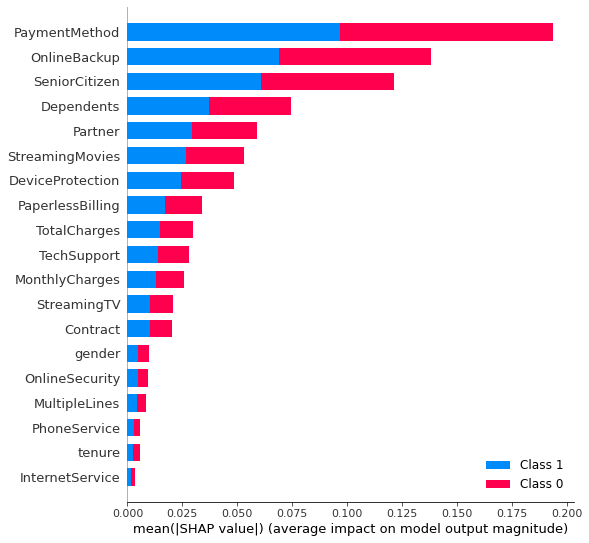

In [40]:
# {'classifier__class_weight': 'balanced',
#  'classifier__max_depth': 7,
#  'classifier__max_features': 'auto',
#  'classifier__min_samples_leaf': 10}

model=RandomForestClassifier(class_weight='balanced',max_depth=7, max_features='auto',min_samples_leaf=10,random_state=44,n_jobs=-1)
X_train_shap=pd.DataFrame(prep_std_ordinal.fit_transform(X_train),columns=X_train.columns)
model.fit(X_train_shap,y_train)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
pred = model.predict(X_train_shap)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_shap)
# np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

shap.summary_plot(shap_values, X_train_shap)

###This plots show feature influence strenght on prediction. 

In [41]:

cross_validate(model,X_)
f1_score(y_val,model_lst[model].predict(X_val)))

SyntaxError: unmatched ')' (3348985370.py, line 2)

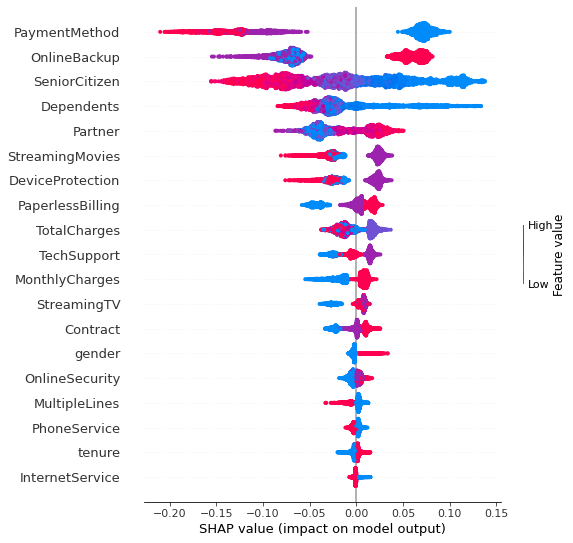

In [ ]:
# How to read the chart:
# This chart shows the strenghts of feature influence on prediction and features values vs strengths of influence
# on y axis features are ordered by influence strength 
# x axis is the scale of how strong is the influence. I.e. positive means feature drag prediciton towards 1, negative means feature drag prediction to 0.
# colour indicates feature values (red being hihg and blue being low)

# Payment method is influencing prediction

shap_values = explainer.shap_values(X_train_shap)
gt=pd.DataFrame(X_train_shap,columns=X_train.columns)
gt
shap.summary_plot(shap_values[1], gt,plot_type = 'dot')

In [ ]:
shap.initjs()
X_test_shap=pd.DataFrame(prep_std_ordinal.transform(X_test),columns=X_test.columns)
shap_values = explainer.shap_values(X_test_shap)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_shap)

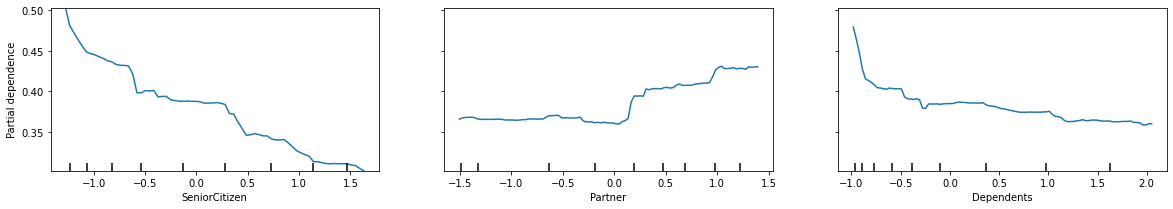

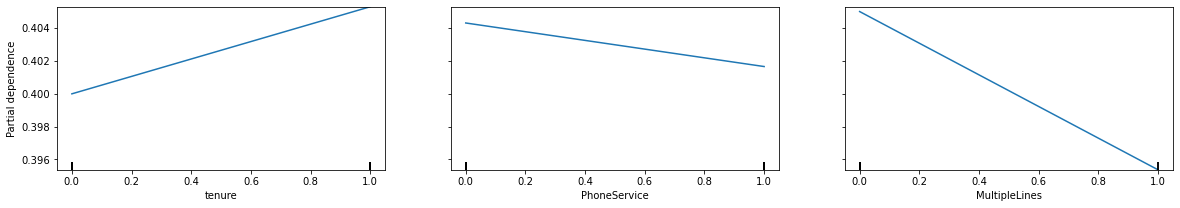

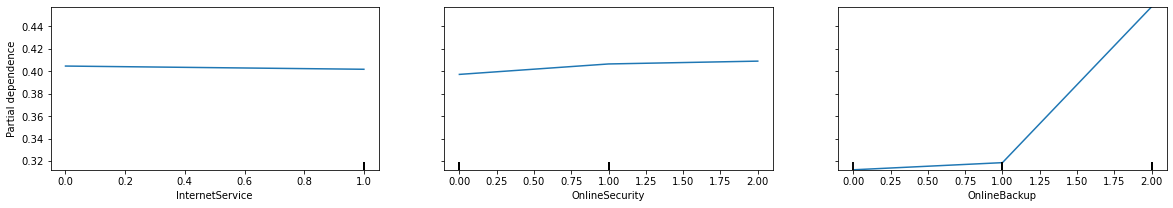

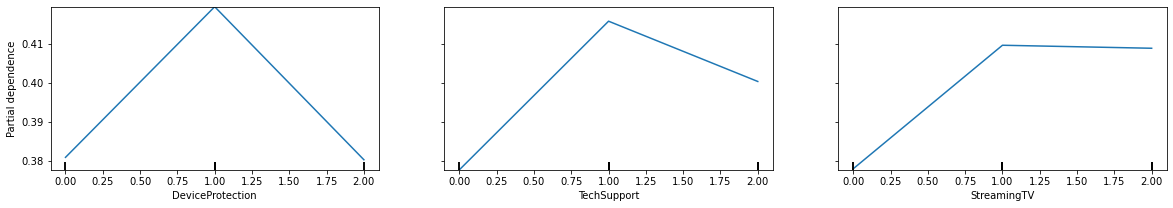

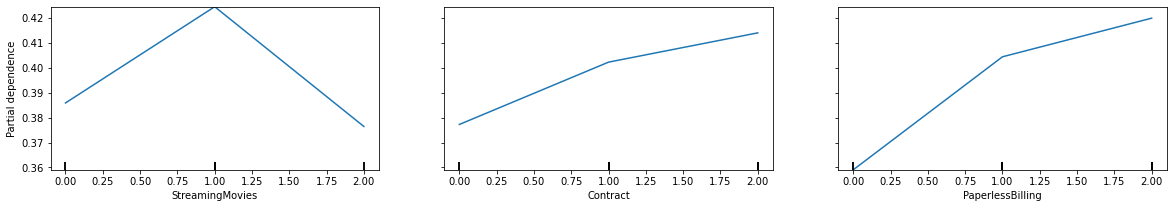

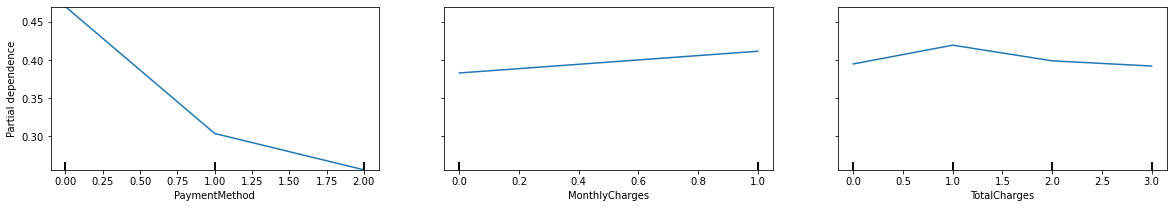

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
features = [1,2,3]
PartialDependenceDisplay.from_estimator(model, gt, features)
features = [4,5,6]
PartialDependenceDisplay.from_estimator(model, gt, features)
features = [7,8,9]
PartialDependenceDisplay.from_estimator(model, gt, features)
features = [10,11,12]
PartialDependenceDisplay.from_estimator(model, gt, features)
features = [13,14,15]
PartialDependenceDisplay.from_estimator(model, gt, features)
features = [16,17,18]
PartialDependenceDisplay.from_estimator(model, gt, features)
# features = [19,20,21]
# PartialDependenceDisplay.from_estimator(model, gt, features)
# features = [21,22,23]
# PartialDependenceDisplay.from_estimator(model, gt, features)
# features = [24,25,26]
# PartialDependenceDisplay.from_estimator(model, gt, features)
# features = [24,25,26]
# PartialDependenceDisplay.from_estimator(model, gt, features)
# features = [27,28,29]
# PartialDependenceDisplay.from_estimator(model, gt, features)
# features = [30,31]
# PartialDependenceDisplay.from_estimator(model, gt, features)

In [ ]:
# How to read the chart:
# This chart shows the strenghts of feature influence on prediction and features values vs strengths of influence
# on y axis features are ordered by influence strength 
# x axis is the scale of how strong is the influence. I.e. positive means feature drag prediciton towards 1, negative means feature drag prediction to 0.
# colour indicates feature values (red being hihg and blue being low)

# Payment method is influencing prediction

shap_values = explainer.shap_values(X_train_shap)
gt=pd.DataFrame(X_train_shap,columns=X_train.columns)
gt
shap.summary_plot(shap_values[1], gt,plot_type = 'dot')

NameError: name 'explainer' is not defined

In [ ]:
from dash import dash, dcc, html, Input, Output, State, ctx, dash_table
from dash._callback_context import callback_context
import dash_bootstrap_components as dbc
from dash.exceptions import PreventUpdate
import plotly.express as px

import base64
import io

# app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app = dash.Dash(__name__,external_stylesheets=[dbc.themes.BOOTSTRAP])

### We will do one page with side bar and content section ###



### definition of cards for loading, running, downloading data ###
#define styling for cards
side_bar_style={
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '10px',
            'textAlign': 'center',
            'margin': '0px'
            }

#define cards
upload_card=dbc.Card([
        dbc.CardHeader('Load data for prediction'),
        dbc.CardBody(dcc.Upload(id='upload-data', children=html.Div(['Drag and Drop or ',html.A('Select Files')]),style=side_bar_style, # Allow multiple files to be uploaded
        multiple=True))
            ],style={'margin': '10px'}
            )
run_card=dbc.Card([
        dbc.CardHeader('Run Prediction'),
        dbc.CardBody([
            html.Button("Run Model", id="btn_model",
            style=side_bar_style),
            dcc.Download(id="download-dataframe")])
            ],style={'margin': '10px'}
            )
download_card=dbc.Card([
        dbc.CardHeader('Download Prediction'),
        dbc.CardBody([
            html.Button("Download CSV", id="btn_download",
            style=side_bar_style),
            ])
            ],style={'margin': '10px'}
            )

welcome_side_bar = html.Div(
    [ 
    #upload data drag & drop
    upload_card, 

    #rund model
    run_card, 
    #download data
    download_card, 
    dcc.Store(id='memory')        
    ],
)

welcome_top_bar=html.Div(dbc.Row([dbc.Col(upload_card),dbc.Col(run_card),dbc.Col(download_card)]))

### content  definition ###
welcome_content = html.Div(id="output-data-upload")
    # dbc.Card([
    #         dbc.CardBody(
    #             [html.H2("Churn Prediction application", className="card_title"),
    #             dbc.Container([
    #             dbc.Label('Please verify that the entered data is correct'),
    #             html.Div(id="table_tab",children="ten tekst1"),
    #             dbc.Alert(id='tbl_out',children='test') ]),
    #             html.Button('Submit', id='submit-val', n_clicks=0),
    #             html.Div(id='container-button-basic',
    #             )
    #             ]) ]) 

## Parse the file that was put into the upload section
def parse_contents(contents, filename, date):
    content_type, content_string = contents.split(',')

    decoded = base64.b64decode(content_string)
    try:
        if 'csv' in filename:
            # Assume that the user uploaded a CSV file
            df = pd.read_csv(
                io.StringIO(decoded.decode('utf-8')))
        elif 'xls' in filename:
            # Assume that the user uploaded an excel file
            df = pd.read_excel(io.BytesIO(decoded))
    except Exception as e:
        print(e)
        return html.Div([
            'There was an error processing this file.'
        ])

    return html.Div([
        html.H5(filename),
        html.H6(datetime.datetime.fromtimestamp(date)),

        dash_table.DataTable(
            style_data={
            'whiteSpace': 'normal',
            'height': 'auto',
            'lineHeight': '15px'
            },
            data=df.to_dict('records'),
            columns=[{'name': i, 'id': i} for i in df.columns]
        ),

        html.Hr(),  # horizontal line

        # For debugging, display the raw contents provided by the web browser
        html.Div('Raw Content'),
        html.Pre(contents[0:200] + '...', style={
            'whiteSpace': 'pre-wrap',
            'wordBreak': 'break-all'
        })
    ])

@app.callback(Output('output-data-upload', 'children'),
              Input('upload-data', 'contents'),
              State('upload-data', 'filename'),
              State('upload-data', 'last_modified'))
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)]
        return children

### callback for run model button
@app.callback(
    Output('table_tab','children'),
    Input("btn_model", "n_clicks"),
    prevent_initial_call=True,
)
def func(n_clicks):
    df=
    return n_clicks

### callback for download results
@app.callback(
    Output("download-dataframe", "data"),
    Input("btn_download", "n_clicks"),
    prevent_initial_call=True,
)
def func(n_clicks):
    return dcc.send_data_frame(df.to_csv, "mydf.csv")

# lets define the three tabs how what they are composed of
# welcome = html.Div(dbc.Row([dbc.Col(welcome_side_bar, width=2),dbc.Col([html.Br(),html.Br(),html.Br(),welcome_content])]))
horiz_welcome = html.Div([welcome_top_bar,dbc.Row(welcome_content)])


predict_churn = html.Div([
    dbc.Card([
            dbc.CardBody(
                [html.H2("SLYTHERIN BANK", className="card_title"),
                                ]) ]) ])

simulate = html.Div([
    dbc.Card([
            dbc.CardBody(
                [html.H2("SLYTHERIN BANK", className="card_title"),
                                ]) ]) ])


#Define the list of available tabs to show in app
# TABS = dbc.Tabs(
#         [
#             dbc.Tab(welcome, label="Welcome Page",tab_id="tab1"),  #Welcome page
#             dbc.Tab(predict_churn, label="Predict Churn",tab_id="tab2"),
#             dbc.Tab(simulate, label="Simulate",tab_id="tab2"),  
#         ], id="tabs"
# )

#define app instance 
app.layout = html.Div([horiz_welcome])


if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [20/May/2022 09:22:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 09:22:02] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 09:22:02] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 09:22:02] "GET /_favicon.ico?v=2.4.1 HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 09:22:02] "GET /_dash-component-suites/dash/dcc/async-upload.js HTTP/1.1" 304 -
127.0.0.1 - - [20/May/2022 09:22:02] "POST /_dash-update-component HTTP/1.1" 200 -


In [ ]:
#Version 2

from dash import dash, dcc, html, Input, Output, State, ctx, dash_table
from dash._callback_context import callback_context
import dash_bootstrap_components as dbc
from dash.exceptions import PreventUpdate
import plotly.express as px

import base64
import io

# app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app = dash.Dash(__name__,external_stylesheets=[dbc.themes.BOOTSTRAP])

### We will do one page with side bar and content section ###



### definition of cards for loading, running, downloading data ###
#define styling for cards
side_bar_style={
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '10px',
            'textAlign': 'center',
            'margin': '0px'
            }

#define cards
upload_card=dbc.Card([
        dbc.CardHeader('Load data for prediction'),
        dbc.CardBody(dcc.Upload(id='upload-data', children=html.Div(['Drag and Drop or ',html.A('Select Files')]),style=side_bar_style, # Allow multiple files to be uploaded
        multiple=True))
            ],style={'margin': '10px'}
            )
run_card=dbc.Card([
        dbc.CardHeader('Run Prediction'),
        dbc.CardBody([
            html.Button("Run Model", id="btn_model",
            style=side_bar_style),
            dcc.Download(id="download-dataframe")])
            ],style={'margin': '10px'}
            )
download_card=dbc.Card([
        dbc.CardHeader('Download Prediction'),
        dbc.CardBody([
            html.Button("Download CSV", id="btn_download",
            style=side_bar_style),
            ])
            ],style={'margin': '10px'}
            )

# welcome_side_bar = html.Div(
#     [ 
#     #upload data drag & drop
#     upload_card, 

#     #rund model
#     run_card, 
#     #download data
#     download_card, 
#     dcc.Store(id='data_store',data=[],storage_type='memory')   #will store here uploaded csv data     
#     ],
# )

welcome_top_bar=html.Div(dbc.Row([dbc.Col(upload_card),dbc.Col(run_card),dbc.Col(download_card)]))

### content  definition ###
welcome_content = html.Div([html.Div(dcc.Graph(id='model-output')),html.Div(id='table_tab',children='To jest tekst 2')])
    # dbc.Card([
    #         dbc.CardBody(
    #             [html.H2("Churn Prediction application", className="card_title"),
    #             dbc.Container([
    #             dbc.Label('Please verify that the entered data is correct'),
    #             html.Div(id="table_tab",children="ten tekst1"),
    #             dbc.Alert(id='tbl_out',children='test') ]),
    #             html.Button('Submit', id='submit-val', n_clicks=0),
    #             html.Div(id='container-button-basic',
    #             )
    #             ]) ]) 

## Parse the file that was put into the upload section
def parse_contents(contents, filename):
    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    try:
        if 'csv' in filename:
            # Assume that the user uploaded a CSV file
            df1 = pd.read_csv(
                io.StringIO(decoded.decode('utf-8')))
        elif 'xls' in filename:
            # Assume that the user uploaded an excel file
            df1 = pd.read_excel(io.BytesIO(decoded))
    except Exception as e:
        print(e)
        return html.Div([
            'There was an error processing this file.'
        ])
    return df1

@app.callback(Output('data_store', 'data'),
              Input('upload-data', 'contents'),
              State('upload-data', 'filename'),
              State('upload-data', 'last_modified'))
def update_output(list_of_contents, list_of_names):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n) for c, n in
            zip(list_of_contents, list_of_names)]
        df_test=pd.DataFrame({'MultipleLines':[1,2,3,4,5,6],'Churn':['Yes','No','Yes','No','No','No']})
        return df_test.to_dict()
        # return children[0].to_dict() #we convert file to dictionary as its the type supported by store

### callback for run model button
@app.callback(
    # Output('table_tab','children'),
    Output('model-output','children'),
    # Input("btn_model", "n_clicks"),
    Input('memory','data'), #take data from store
    prevent_initial_call=True,
)
# def func(n_clicks,data):
def func(data):
    df1= pd.DataFrame(data)
    print(df1)
    fig = px.bar(df1, x='MultipleLines', color="Churn",barmode="group")
    return fig

# ### callback for download results
# @app.callback(
#     Output("download-dataframe", "data"),
#     Input("btn_download", "n_clicks"),
#     prevent_initial_call=True,
# )
# def func(n_clicks):
#     return dcc.send_data_frame(df1.to_csv, "mydf.csv")

# lets define the three tabs how what they are composed of
# welcome = html.Div(dbc.Row([dbc.Col(welcome_side_bar, width=2),dbc.Col([html.Br(),html.Br(),html.Br(),welcome_content])]))
horiz_welcome = html.Div([welcome_top_bar,dbc.Row(welcome_content)])


predict_churn = html.Div([
    dbc.Card([
            dbc.CardBody(
                [html.H2("SLYTHERIN BANK", className="card_title"),
                                ]) ]) ])

simulate = html.Div([
    dbc.Card([
            dbc.CardBody(
                [html.H2("SLYTHERIN BANK", className="card_title"),
                                ]) ]) ])


#Define the list of available tabs to show in app
# TABS = dbc.Tabs(
#         [
#             dbc.Tab(welcome, label="Welcome Page",tab_id="tab1"),  #Welcome page
#             dbc.Tab(predict_churn, label="Predict Churn",tab_id="tab2"),
#             dbc.Tab(simulate, label="Simulate",tab_id="tab2"),  
#         ], id="tabs"
# )

#define app instance 
app.layout = html.Div([horiz_welcome])


if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving 

 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [20/May/2022 12:05:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 12:05:02] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 12:05:02] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 12:05:02] "GET /_favicon.ico?v=2.4.1 HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 12:05:02] "GET /_dash-component-suites/dash/dcc/async-upload.js HTTP/1.1" 304 -
127.0.0.1 - - [20/May/2022 12:05:02] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [20/May/2022 12:05:02] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -


In [ ]:
df_test.to_dict()

{'MultipleLines': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6},
 'Churn': {0: 'Yes', 1: 'No', 2: 'Yes', 3: 'No', 4: 'No', 5: 'No'}}

In [ ]:
df_test=pd.DataFrame({'MultipleLines':[1,2,3,4,5,6],'Churn':['Yes','No','Yes','No','No','No']})
fig = px.bar(df_test, x='MultipleLines', color="Churn",barmode="group")
fig.show()

In [ ]:
# Version3
from dash import dash, dcc, html, Input, Output, State, ctx, dash_table
from dash._callback_context import callback_context
import dash_bootstrap_components as dbc
from dash.exceptions import PreventUpdate
import plotly.express as px

import base64
import io
import datetime

# app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app = dash.Dash(__name__,external_stylesheets=[dbc.themes.BOOTSTRAP])

### We will do one page with side bar and content section ###



### definition of cards for loading, running, downloading data ###
#define styling for cards
side_bar_style={
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '10px',
            'textAlign': 'center',
            'margin': '0px'
            }

#define cards
upload_card=dbc.Card([
        dbc.CardHeader('Load data for prediction'),
        dbc.CardBody(dcc.Upload(id='upload-data', children=html.Div(['Drag and Drop or ',html.A('Select Files')]),style=side_bar_style, # Allow multiple files to be uploaded
        multiple=True))
            ],style={'margin': '10px'}
            )
run_card=dbc.Card([
        dbc.CardHeader('Run Prediction'),
        dbc.CardBody([
            html.Button("Run Model", id="btn_model",
            style=side_bar_style),
            dcc.Download(id="download-dataframe")])
            ],style={'margin': '10px'}
            )
download_card=dbc.Card([
        dbc.CardHeader('Download Prediction'),
        dbc.CardBody([
            html.Button("Download CSV", id="btn_download",
            style=side_bar_style),
            ])
            ],style={'margin': '10px'}
            )

welcome_side_bar = html.Div(
    [ 
    #upload data drag & drop
    upload_card, 

    #rund model
    run_card, 
    #download data
    download_card, 
    dcc.Store(id='memory')        
    ],
)

welcome_top_bar=html.Div(dbc.Row([dbc.Col(upload_card),dbc.Col(run_card),dbc.Col(download_card)]))

### content  definition ###
welcome_content = html.Div(id="output-data-upload")
    # dbc.Card([
    #         dbc.CardBody(
    #             [html.H2("Churn Prediction application", className="card_title"),
    #             dbc.Container([
    #             dbc.Label('Please verify that the entered data is correct'),
    #             html.Div(id="table_tab",children="ten tekst1"),
    #             dbc.Alert(id='tbl_out',children='test') ]),
    #             html.Button('Submit', id='submit-val', n_clicks=0),
    #             html.Div(id='container-button-basic',
    #             )
    #             ]) ]) 

## Parse the file that was put into the upload section
def parse_contents(contents, filename, date):
    content_type, content_string = contents.split(',')

    decoded = base64.b64decode(content_string)
    try:
        if 'csv' in filename:
            # Assume that the user uploaded a CSV file
            df = pd.read_csv(
                io.StringIO(decoded.decode('utf-8')))
        elif 'xls' in filename:
            # Assume that the user uploaded an excel file
            df = pd.read_excel(io.BytesIO(decoded))
    except Exception as e:
        print(e)
        return html.Div([
            'There was an error processing this file.'
        ])

    return html.Div([
        html.H5(filename),
        dcc.Graph(figure=px.bar(df, x='MultipleLines', color="Churn",barmode="group")),
        html.H6(datetime.datetime.fromtimestamp(date)),

        dash_table.DataTable(
            style_data={
            'whiteSpace': 'normal',
            'height': 'auto',
            'lineHeight': '15px'
            },
            data=df.to_dict('records'),
            columns=[{'name': i, 'id': i} for i in df.columns]
        ),

        html.Hr(),  # horizontal line

        # For debugging, display the raw contents provided by the web browser
        html.Div('Raw Content'),
        html.Pre(contents[0:200] + '...', style={
            'whiteSpace': 'pre-wrap',
            'wordBreak': 'break-all'
        })
    ])

@app.callback(Output('output-data-upload', 'children'),
              Input('upload-data', 'contents'),
              State('upload-data', 'filename'),
              State('upload-data', 'last_modified'))
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)]
        return children

### callback for run model button
@app.callback(
    Output('table_tab','children'),
    Input("btn_model", "n_clicks"),
    prevent_initial_call=True,
)
def func(n_clicks):
    return n_clicks

### callback for download results
@app.callback(
    Output("download-dataframe", "data"),
    Input("btn_download", "n_clicks"),
    prevent_initial_call=True,
)
def func(n_clicks):
    return dcc.send_data_frame(df.to_csv, "mydf.csv")

# lets define the three tabs how what they are composed of
# welcome = html.Div(dbc.Row([dbc.Col(welcome_side_bar, width=2),dbc.Col([html.Br(),html.Br(),html.Br(),welcome_content])]))
horiz_welcome = html.Div([welcome_top_bar,dbc.Row(welcome_content)])


predict_churn = html.Div([
    dbc.Card([
            dbc.CardBody(
                [html.H2("SLYTHERIN BANK", className="card_title"),
                                ]) ]) ])

simulate = html.Div([
    dbc.Card([
            dbc.CardBody(
                [html.H2("SLYTHERIN BANK", className="card_title"),
                                ]) ]) ])


#Define the list of available tabs to show in app
# TABS = dbc.Tabs(
#         [
#             dbc.Tab(welcome, label="Welcome Page",tab_id="tab1"),  #Welcome page
#             dbc.Tab(predict_churn, label="Predict Churn",tab_id="tab2"),
#             dbc.Tab(simulate, label="Simulate",tab_id="tab2"),  
#         ], id="tabs"
# )

#define app instance 
app.layout = html.Div([horiz_welcome])


if __name__ == '__main__':
    app.run_server()


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [20/May/2022 10:28:41] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:28:41] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:28:41] "GET /_dash-component-suites/dash/dcc/async-upload.js HTTP/1.1" 304 -
127.0.0.1 - - [20/May/2022 10:28:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:28:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:28:42] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:28:42] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:28:42] "GET /_dash-component-suites/dash/dcc/async-upload.js HTTP/1.1" 304 -
127.0.0.1 - - [20/May/2022 10:28:42] "GET /_favicon.ico?v=2.4.1 HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:28:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:29:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2022 10:29:45] "

In [ ]:
import plotly.express as px
fig = px.bar(df, x='MultipleLines', color="Churn",barmode="group")
fig.show()

In [ ]:
import sklearn

dir(sklearn)
sklearn.__version__


'1.0.2'